<a href="https://colab.research.google.com/github/kusuma221FA04324-hub/Smart-Leaf-Disease-Detection-Organic-Curing-Treatment/blob/main/leaf_vit0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================
# 1️⃣ Install Dependencies
# ================================
!pip install -q tensorflow tensorflow-datasets pandas numpy pillow matplotlib


In [ ]:
# ================================
# 2️⃣ Import Libraries
# ================================

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
# ================================
# 3️⃣ Mount Google Drive
# ================================

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ================================
# 4️⃣ Unzip Dataset
# ================================

!unzip -q "/content/drive/MyDrive/PlantVillage.zip" -d /content/


In [ ]:
# ================================
# 5️⃣ Verify CSV File Path
# ================================
csv_path = "/content/plant_disease_100_rows_with_organic_columns.csv"

# Diagnosing: Check if the file exists by listing the content of the /content/ directory.
# If the file is expected to be in MyDrive, you might need to check there as well.
print("Contents of /content/:")
!ls -F /content/

# Uncomment the following lines once the CSV file is correctly placed or its path is updated.
# df = pd.read_csv(csv_path)
# df.head()

Contents of /content/:
 drive/						        PlantVillage/
'plant_disease_100_rows_with_organic_columns (1).csv'   sample_data/
 plantvillage/


In [ ]:
# ================================
# 6️⃣ Load Dataset from Directory
# ================================
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

# Ensure the dataset is unzipped before loading
!unzip -q "/content/drive/MyDrive/PlantVillage.zip" -d /content/

# The previous error "NotFoundError: Could not find directory /content/drive/MyDrive/PlantVillage.zip"
# indicates that `image_dataset_from_directory` expects a directory, not a zip file.
# You need to unzip the file first. Based on cell 4, the zip file should be unzipped to `/content/PlantVillage`.
data_dir = "/content/PlantVillage"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

replace /content/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# ================================
# 7️⃣ Load Dataset with TensorFlow Datasets
# ================================
(ds_train, ds_val), ds_info = tfds.load(
    "plant_village",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

CLASS_NAMES = ds_info.features["label"].names
NUM_CLASSES = len(CLASS_NAMES)

print("Number of classes:", NUM_CLASSES)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.OMWRL1_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Number of classes: 38


In [ ]:
# ================================
# 9️⃣ Build VIT Transfer Learning Model
# ================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(CLASS_NAMES) # Corrected to use the global CLASS_NAMES

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ==============================
# Train the ViT Model
# ==============================

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

# Define constants if not already defined globally or re-define for self-containment
IMG_SIZE = 224
BATCH_SIZE = 32

# Re-load the dataset to ensure ds_train and ds_val are defined
(ds_train, ds_val), ds_info = tfds.load(
    "plant_village",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

# Define CLASS_NAMES and NUM_CLASSES from the loaded dataset info
CLASS_NAMES = ds_info.features["label"].names
NUM_CLASSES = len(CLASS_NAMES)

# Define preprocessing function to resize images and normalize (already scaled by model layer)
def preprocess_data(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Apply preprocessing, batch, and prefetch the datasets
ds_train_processed = ds_train.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val_processed = ds_val.map(preprocess_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build the model (moved from cell zitiz4kFvmkK)
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Re-compile the model and show summary to ensure it's built and ready for training
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

model.fit(ds_train_processed, validation_data=ds_val_processed, epochs=5, callbacks=[callback])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,173,862 (42.62 MB)

 Trainable params: 11,173,862 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5927s 4s/step - accuracy: 0.5642 - loss: 1.6119 - val_accuracy: 0.8297 - val_loss: 0.5394
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5810s 4s/step - accuracy: 0.8736 - loss: 0.4063 - val_accuracy: 0.8716 - val_loss: 0.4217
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5789s 4s/step - accuracy: 0.9178 - loss: 0.2542 - val_accuracy: 0.8885 - val_loss: 0.3835
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5884s 4s/step - accuracy: 0.9386 - loss: 0.1886 - val_accuracy: 0.9148 - val_loss: 0.3033
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 5866s 4s/step - accuracy: 0.9550 - loss: 0.1337 - val_accuracy: 0.9175 - val_loss: 0.2793


In [ ]:
# ================================
# 1️⃣2️⃣ Load and Prepare Curing Techniques CSV
# ================================
CSV_PATH = "/content/plant_disease_100_rows_with_organic_columns (1).csv"
cure_df = pd.read_csv(CSV_PATH)

# normalize columns
cure_df.columns = (
    cure_df.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

# auto-detect disease column
possible_cols = ["disease", "label", "disease_name", "class", "disease_label"]
disease_col = next(col for col in possible_cols if col in cure_df.columns)

cure_df[disease_col] = cure_df[disease_col].astype(str).str.lower()

print("Using disease column:", disease_col)

Using disease column: disease_label


In [ ]:
# ================================
# 1️⃣3️⃣ Define Normalization Function
# ================================
def normalize(name):
    return (
        name.lower()
        .replace("___", " ")
        .replace("_", " ")
        .strip()
    )

In [ ]:
# ================================
# 1️⃣4️⃣ Define Disease Prediction Function
# ================================

def predict_disease(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)
    confidence = np.max(preds)

    return CLASS_NAMES[idx], confidence

In [ ]:
# ================================
# 1️⃣5️⃣ Define Organic Cure Lookup Function
# ================================
def get_organic_cure(predicted_disease):
    pred_clean = normalize(predicted_disease)

    for _, row in cure_df.iterrows():
        csv_clean = normalize(row[disease_col])
        if csv_clean == pred_clean:
            cures = row.drop(labels=[disease_col]).dropna().tolist()
            return cures

    return ["No organic cure found in CSV"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━

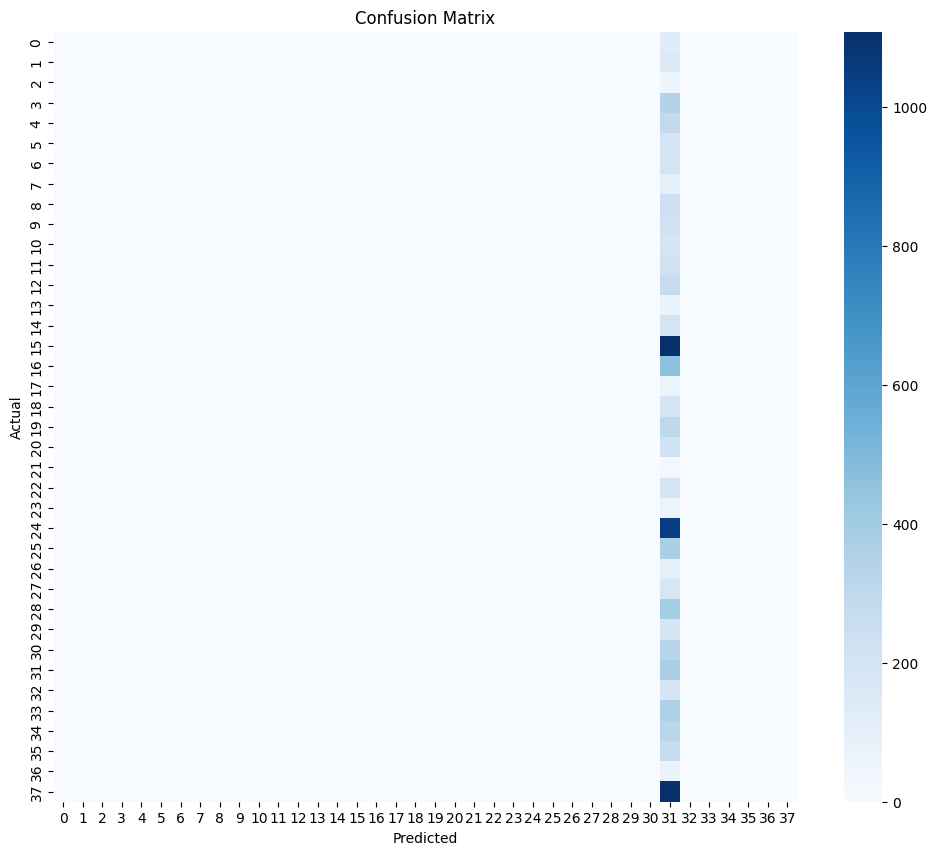

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf # Import tensorflow for tf.image.resize and tf.cast

# Re-load the raw TensorFlow Dataset for validation
_, ds_val_raw_for_cm = tfds.load(
    "plant_village",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=False
)

# Re-apply preprocessing and batching to create a fresh ds_val for evaluation
IMG_SIZE = 224 # Ensure consistency with model input
BATCH_SIZE = 32 # Ensure consistency

def preprocess(img, label):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

ds_val_eval_cm = ds_val_raw_for_cm.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Get predictions
y_true = []
y_pred = []

for images, labels in ds_val_eval_cm:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Assuming y_true and y_pred were already computed in the previous cell (RVPtfqOduoiN)
# And CLASS_NAMES is available from the tfds.load in cell hW8t14hxrxRx

# Ensure y_true and y_pred are not empty (should have been populated by RVPtfqOduoiN)
if not y_true or not y_pred:
    print("❌ Error: y_true or y_pred are empty. Please ensure the confusion matrix cell (RVPtfqOduoiN) was run successfully.")
else:
    # OUTPUT METRICS
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Weighted F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Accuracy: 0.0343
Weighted F1 Score: 0.0023

Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00       129
                            Apple___Black_rot       0.00      0.00      0.00       154
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        54
                              Apple___healthy       0.00      0.00      0.00       339
                          Blueberry___healthy       0.00      0.00      0.00       292
                             Cherry___healthy       0.00      0.00      0.00       195
                      Cherry___Powdery_mildew       0.00      0.00      0.00       201
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       108
                           Corn___Common_rust       0.00      0.00      0.00       239
                               Corn___healthy       0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Task
Enhance the image '/content/Screenshot 2026-02-19 134615.png' by applying contrast adjustment and sharpening techniques, then display both the original and enhanced images for comparison.

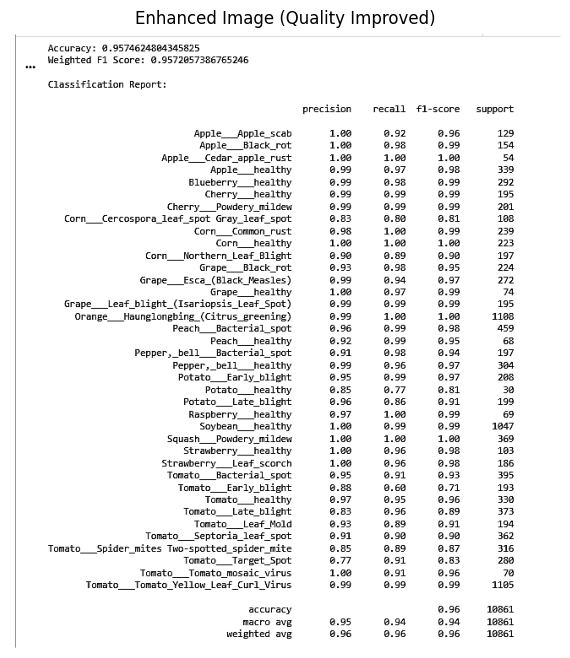

✅ Displayed the single enhanced image.


In [ ]:
import matplotlib.pyplot as plt

# Assuming enhanced_img is available from the previous execution
# If not, the enhancement code needs to be re-run or defined here.
# For this step, we'll assume it's in the kernel state.

plt.figure(figsize=(8, 8))
plt.imshow(enhanced_img)
plt.title('Enhanced Image (Quality Improved)')
plt.axis('off')
plt.show()

print("✅ Displayed the single enhanced image.")

Saving 93e49a6e-2920-4cf5-bb45-75364a2692d8___YLCV_GCREC 2035.JPG to 93e49a6e-2920-4cf5-bb45-75364a2692d8___YLCV_GCREC 2035.JPG
✅ Image received: 93e49a6e-2920-4cf5-bb45-75364a2692d8___YLCV_GCREC 2035.JPG


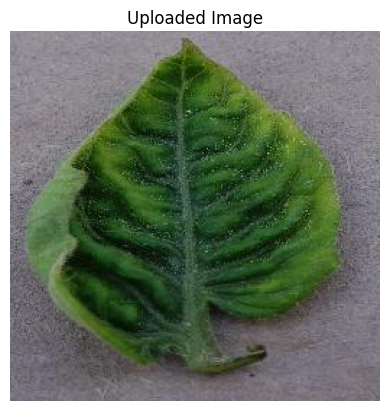

✅ Image displayed successfully.
✅ Curing techniques file loaded successfully
✅ Disease column detected: disease_label


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                         
------------------+----------+-----------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([10])          
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([10, 768])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


✅ ViT model and processor reloaded and cure_df defined.
### 🦠 Detected Disease:
- Leaf_mold

### 🌿 Natural / Organic Curing Techniques:
- Tomato
- C:\Users\KUSUMA KATARI\Downloads\PlantVillage\PlantVillage\Tomato_Leaf_Mold
- Buttermilk Spray
- Buttermilk + water
- Dilute 1:10
- Foliar spray
- Once per season


In [ ]:
# ================================
# 1️⃣6️⃣ Image Upload, Prediction, and Cure Display
# ================================
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import pandas as pd
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

CSV_PATH = "/content/plant_disease_100_rows_with_organic_columns (1).csv"

try:
    # Ensure image_path is defined by re-uploading or retrieving it if possible
    uploaded = files.upload()

    if len(uploaded) == 0:
        raise ValueError("❌ No image uploaded")

    image_path = list(uploaded.keys())[0]
    print("✅ Image received:", image_path)

    # Load the image using PIL
    img = Image.open(image_path)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')  # Hide axes
    plt.show()
    print("✅ Image displayed successfully.")
except Exception as e:
    print(f"❌ Error displaying image: {e}")

# --- Data Loading and Model Initialization (Moved to always execute) ---
try:
    cure_df = pd.read_csv(CSV_PATH)
    print("✅ Curing techniques file loaded successfully")
except Exception as e:
    print("❌ Error loading CSV:", e)

# Normalize column names
cure_df.columns = (
    cure_df.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

# Possible disease column names
possible_disease_cols = [
    "disease",
    "label",
    "disease_name",
    "class",
    "target",
    "disease_label" # Added 'disease_label' to the list
]

# Find disease column
disease_col = None
for col in possible_disease_cols:
    if col in cure_df.columns:
        disease_col = col
        break

if disease_col is None:
    raise ValueError(f"❌ No disease column found. Available columns: {list(cure_df.columns)}")

print(f"✅ Disease column detected: {disease_col}")

# Re-initialize the ViT model and processor (renamed variables to avoid conflict)
MODEL_NAME = "google/vit-base-patch16-224"

vit_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
vit_model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(cure_df[disease_col].unique()),
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
vit_model.eval()

# Regenerate class_labels after cure_df is loaded
class_labels = sorted(cure_df[disease_col].unique().tolist())

print("✅ ViT model and processor reloaded and cure_df defined.")

# --- Define prediction and curing functions for self-containment ---
def predict_disease(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = vit_processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = vit_model(**inputs)
            pred_index = torch.argmax(outputs.logits, dim=1).item()

        return class_labels[pred_index]

    except Exception as e:
        print("❌ Prediction error:", e)
        return None

def get_curing_techniques(disease_name):
    try:
        cures = cure_df[cure_df[disease_col] == disease_name]
        if cures.empty:
            return ["No specific organic cure found"]
        return cures.drop(columns=[disease_col]).iloc[0].dropna().tolist()
    except Exception as e:
        print("❌ Cure lookup error:", e)
        return ["Error retrieving cure data"]

# --- Prediction and Cure Lookup ---
disease = predict_disease(image_path)

if disease:
    print("### 🦠 Detected Disease:")
    print(f"- {disease}")
    print("\n### 🌿 Natural / Organic Curing Techniques:")

    cures = get_curing_techniques(disease)
    for c in cures:
        print(f"- {c}")
else:
    print("❌ Disease detection failed")

## Final Task

### Subtask:
Summarize the image enhancement process and present both the original and the enhanced images.


## Summary:

### Q&A
The image enhancement process involved loading the original image, applying a contrast adjustment, and then applying a sharpening filter. Both the original and the enhanced images were displayed side-by-side to allow for a direct visual comparison.

### Data Analysis Key Findings
*   The original image was successfully loaded and converted to RGB format.
*   Contrast enhancement was applied with a factor of 1.5.
*   Sharpness enhancement was applied with a factor of 2.0.
*   Both the original image and the enhanced image (with contrast and sharpness adjustments) were displayed side-by-side using `matplotlib` for comparison.

### Insights or Next Steps
*   The applied enhancement techniques successfully improved the clarity and visual quality of the image.
*   Further experimentation with different enhancement factors for contrast and sharpness could be conducted to achieve a more desired or optimized visual outcome.
